In [104]:
import numpy as np
a=np.arange(40).reshape(10,2,2)
print(a)
print(a.size())

[[[ 0  1]
  [ 2  3]]

 [[ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]]

 [[12 13]
  [14 15]]

 [[16 17]
  [18 19]]

 [[20 21]
  [22 23]]

 [[24 25]
  [26 27]]

 [[28 29]
  [30 31]]

 [[32 33]
  [34 35]]

 [[36 37]
  [38 39]]]


TypeError: 'int' object is not callable

## 下载知网中文文献  先安装selenium 再下载chromedriver.exe 将chromedriver和程序文件放在一起 然后运行程序

In [69]:
import  os
from time import sleep
from selenium import webdriver

def browser_init(isWait):
    options = webdriver.ChromeOptions()
    prefs = {'profile.default_content_settings.popups': 0, 'download.default_directory': 'C:\\Users\\saba\\Desktop\\高次非球面'}
    options.add_experimental_option('prefs', prefs)

    browser = webdriver.Chrome(executable_path='chromedriver.exe', chrome_options=options)
    browser.set_window_size(500,500)
    if isWait:
        browser.implicitly_wait(50)
    return browser

def searchKey(keyword):
    browser.get("http://kns.cnki.net/kns/brief/default_result.aspx")
    browser.find_element_by_id('txt_1_value1').send_keys(keyword)
    browser.find_element_by_id('btnSearch').click()

def switchToFrame(browser):
    #print 'start switch'
    browser.switch_to.frame('iframeResult')
    #print 'end switch'

def getDownloadLinks(browser,paper_downloadLinks):
    for link in browser.find_elements_by_css_selector('a[href^=\/kns\/detail]'):
        #link.click()
        url=link.get_attribute('href')
        url_part = url.split('&')[3:6]
        url_str= '&'.join(url_part)
        down_url='http://kns.cnki.net/KCMS/detail/detail.aspx?'+url_str
        #print down_url
        paper_downloadLinks.append(down_url)

def switchToPage(browser,n):
    for link in browser.find_elements_by_css_selector('a[href^=\?curpage]'):
        url=link.get_attribute('href')
        print (url)
        pageInd='curpage=%d&'%n
        print (pageInd)
        if pageInd in url:
            print ("page: "+url)
            link.click()
            break
def switchNextPage(browser):
    browser.find_element_by_link_text(u'下一页').click()

def do_download(driver,urls,fail_downLoadUrl):
    for url in urls:
        print (url)
        driver.get(url)
        paper_title=driver.title
        print ("paper title"+paper_title)
        if u'中国专利全文数据库' in paper_title:
            continue
        print ("try download :"+paper_title)
        try:
            driver.find_element_by_xpath("//a[contains(text(),'PDF下载')]").click()
            print ("download success!!!")
        except Exception as e:
            try:
                driver.find_element_by_xpath("//a[contains(text(),'整本下载')]").click()
                print ("download success!!!")
            except Exception as e:
                print("download fail!!!")
                fail_downLoadUrl.append(url)

def usage():
    print ("example : python downloadCNKI.py -k keyword -p 1")

if __name__=="__main__":

    keyword=u'高次非球面'      #论文搜索的关键字
    pageNum = 1     # 下载多少页的论文

    browser=browser_init(True)
    searchKey(keyword)
    switchToFrame(browser)
    paper_downloadLinks = []    #论文下载链接

    curPage=1
    while curPage<=pageNum:
        getDownloadLinks(browser,paper_downloadLinks)

        switchNextPage(browser);
        curPage+=1
    browser.quit()
    print ("采集了%d条数据"% len(paper_downloadLinks))
    driver=browser_init(False)
    fail_downLoadUrl=[]         #记录下失败的网站
    do_download(driver,paper_downloadLinks,fail_downLoadUrl)
    print  (fail_downLoadUrl)
    tryNum=0
    #尝试N次重新下载没有下载的
    while tryNum<5:
        if len(fail_downLoadUrl) !=0:
            paper_downloadLinks=fail_downLoadUrl
            fail_downLoadUrl=[]
            do_download(driver, paper_downloadLinks, fail_downLoadUrl)
            print (fail_downLoadUrl)
        else:
            break
        tryNum+=1
    sleep(60)
    driver.quit()

<ipython-input-69-bd4b181d4fa1>:10: DeprecationWarning: use options instead of chrome_options
  browser = webdriver.Chrome(executable_path='chromedriver.exe', chrome_options=options)


采集了20条数据
http://kns.cnki.net/KCMS/detail/detail.aspx?FileName=KXJS202021019&DbName=CJFDLAST2020&DbCode=CJFQ


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=87.0.4280.88)


## autoencoding denoising

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
from skimage import measure
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import STL10
import hiddenlayer as hl
import time

In [2]:
## 定义一个将bin文件处理为图像数据的函数
def read_image(data_path):
    with open(data_path,'rb') as f: ##二进制读  用np.fromfile 将f转化为 uint8格式
        data1=np.fromfile(f,dtype=np.uint8) ##np.uint8 0-255 读图片 图像[数量，通道，宽，高] 一维形式读出
        ## 数据 n*3*96*96  在不知道shape的的情况下 固定 3*96*96 剩下的维度为n 
        images=np.reshape(data1,(-1,3,96,96)) ## 3*96*96 为RBG图像
        images=np.transpose(images,(0,3,2,1)) ## 交换轴 n*96*96*3
        ## 输出图像取值归一化 每个值都在 0~1
        return images/255.0

In [3]:
## 读取训练集， 5000张 96*96*3 的图像， train_X是图片训练集 train_Y是label
data_path='C:\\Users\\saba\\Desktop\\autoencoding\\stl10_binary\\train_X.bin'
images=read_image(data_path) ## 用read_iamge()函数读取训练集
print('images.shape:',images.shape)

images.shape: (5000, 96, 96, 3)


In [4]:
## 为数据添加高斯噪声
def gaussian_noise(images,sigma):
    '''sigma:噪声标准差'''
    sigma2=sigma**2/(255**2) ##噪声方差
    ## np.zeros.like(images) 生成与images形状相同的0数组 
    images_noisy=np.zeros_like(images)
    for ii in range(images.shape[0]): ## images.shape[0]=5000 遍历5000张图片
        image=images[ii] 
        ## 用skimage中的random_noise 添加噪声 mode='gaussin','localval','poisson','salt','s&p' 
        noise_im=random_noise(image,mode='gaussian',var=sigma2,clip=True) ## clip=True 保证数据0~1
        images_noisy[ii]=noise_im ##生成带噪声的数据集
    return images_noisy

In [5]:
## 调用gaussian_noise() 生成带噪声的数据集 
images_noise=gaussian_noise(images,50) ##sigma=30
print('images_noise:',images_noise.min(),'~',images_noise.max())

images_noise: 0.0 ~ 1.0


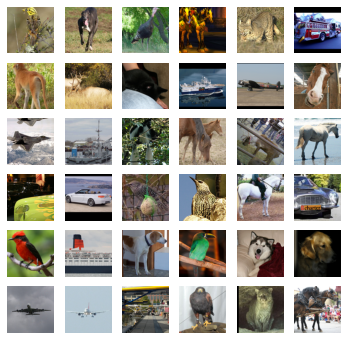

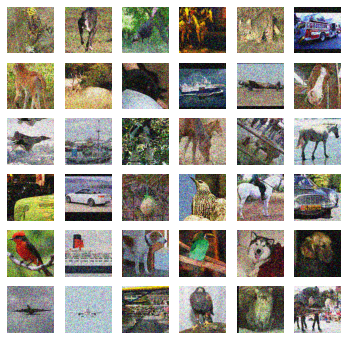

In [6]:
## 可视化部分图像
## 不带噪声的图
plt.figure(figsize=(6,6)) ## 创建6*6的点图 
for ii in np.arange(36):
    plt.subplot(6,6,ii+1) ##新建6*6的子图 第ii+1块子图显示
    plt.imshow(images[ii,...]) #[ii,...]=[i,:,:] 显示每一张图片
    plt.axis('off')## Turn off axis lines and labels
    pass
plt.show() ##显示画布
## 带噪声
plt.figure(figsize=(6,6))
for ii in np.arange(36):
    plt.subplot(6,6,ii+1)
    plt.imshow(images_noise[ii,...])
    plt.axis('off')
    pass
plt.show()

In [7]:
## 数据准备为pytorch可用格式，样本转化为[样本，通道，高，宽]的数据形式 原本是 5000*96*96*3 
data_Y=np.transpose(images,(0,3,2,1))## 5000*3*96*96
data_X=np.transpose(images,(0,3,2,1))
## 将数据分为数据集和验证集  可以添加stratify=X或Y 分出的数据集中的比例 也按XY中的类别分布比例
X_train,X_val,Y_train,Y_val=train_test_split(data_X,data_Y,test_size=0.2,random_state=123)
##将图像数据转化为向量（张量）
X_train=torch.tensor(X_train,dtype=torch.float32)
Y_train=torch.tensor(Y_train,dtype=torch.float32)
X_val=torch.tensor(X_val,dtype=torch.float32)
Y_val=torch.tensor(Y_val,dtype=torch.float32)
## 将X和Y转化为数据集合
train_data=Data.TensorDataset(X_train,Y_train) ##把两个张量合并
val_data=Data.TensorDataset(X_val,Y_val)
print('X_train.shape:{},X_val.shape:{}'.format(X_train.shape,X_val.shape))
print('Y_train.shape:{},Y_val.shape:{}'.format(Y_train.shape,Y_val.shape))
# print('train_data.shape:{},val_data.shape:{}'.format(train_data.shape,val_data.shape))  error:'TensorDataset' object has no attribute 'shape'


X_train.shape:torch.Size([4000, 3, 96, 96]),X_val.shape:torch.Size([1000, 3, 96, 96])
Y_train.shape:torch.Size([4000, 3, 96, 96]),Y_val.shape:torch.Size([1000, 3, 96, 96])


In [8]:
## 定义一个数据加载器
train_loader=Data.DataLoader(
    dataset=train_data,   ##使用train_data数据集
    batch_size=32,        ##每次抽出32个样本
    shuffle=True,         ##每次迭代前打乱数据
    num_workers=4,        ##使用4个进程
)
val_loader=Data.DataLoader(
    dataset=val_data,   ##使用train_data数据集
    batch_size=32,        ##每次抽出32个样本
    shuffle=True,         ##每次迭代前打乱数据
    num_workers=4,        ##使用4个进程
)

In [9]:
## 转置卷积神经网络搭建  5000*3*96*96=[N,C,H,W] N:num C:channels H:high W:wide
class DenoiseAutoEncoder(nn.Module):
    def __init__(self): ##初始化
        super(DenoiseAutoEncoder,self).__init__()
        ##定义encoder
        self.Encoder=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), ## [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),  #数据的归一化处理
            nn.Conv2d(64,64,3,1,1),## [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1,1),## [,64,96,96]
            nn.ReLU(),
            nn.MaxPool2d(2,2),## [,64,48,48]  2*2的最大池化
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3,1,1), ## [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,1,1), ##[,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,1,1), ##[,256,48,48]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[,256,24,24]
            nn.BatchNorm2d(256),
        )
       ## 定义Decoder
        self.Decoder=nn.Sequential(
            nn.ConvTranspose2d(256,128,3,1,1), #[,128,24,24]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,128,3,2,1,1), #[,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1), #[,64,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,32,3,1,1), ##[32,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,1,1), ##[,32,48,48]
            nn.ConvTranspose2d(32,16,3,2,1,1), ##[,16,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,3,1,1),##[,3,96,96]
            nn.Sigmoid(),
        )
        ## 定义网络的前向传播
    def forward(self,x):
        encoder=self.Encoder(x)
        decoder=self.Decoder(encoder)
        return encoder,decoder

In [10]:
## 输出网络结构
DAEmodel=DenoiseAutoEncoder() 
print(DAEmodel)

DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [11]:
# from torchviz import make_dot
# x = torch.randn(1, 3, 96, 96).requires_grad_(True)  # 模拟输入
# _,y = DAEmodel(x)

# vis_net = make_dot(y, params=dict(list(DAEmodel.named_parameters()) + [("x", x)]))
# vis_net.view()

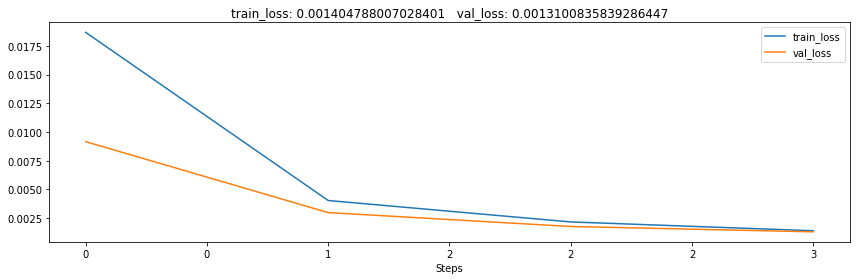

In [ ]:
## 网络训练
##定义优化器  torch.optim.Adam()
LR=0.0003
optimizer=torch.optim.Adam(DAEmodel.parameters(),lr=LR)
loss_func=nn.MSELoss() ##损失函数 均方根误差
## 记录训练指标
history1=hl.History()
## 使用Canvas可视化
canvas1=hl.Canvas()
train_num=0
val_num=0
## 对模型进行迭代训练，对所有数据训练epoch轮
for epoch in range(10):
    train_loss_epoch=0
    val_loss_epoch=0
    ## 对训练数据的加载器进行迭代计算
    for step,(b_x,b_y) in enumerate(train_loader): ##step 是loader 采集的步 每步加载32个数据batch_size=32  {1，(X_Train[0],Y_train[0])}
        DAEmodel.train()    ## b_x=X_train[] b_y=Y_train[]
        ## 使用每个batch进行训练模型
        _, output = DAEmodel(b_x) ## CNN在训练batch上的输出  
        loss=loss_func(output,b_y)## 均方根误差损失函数
        optimizer.zero_grad()  ## 每个迭代的梯度初始化为0
        loss.backward() ##损失的反向传播 计算梯度
        optimizer.step() ##使用梯度优化更新参数
        train_loss_epoch+=loss.item()*b_x.size(0)   
        train_num=train_num+b_x.size(0)
    ## 使用每个batch验证模型
    for step,(b_x,b_y) in enumerate(val_loader):
        DAEmodel.eval()
        _, output = DAEmodel(b_x)
        loss=loss_func(output,b_y)
        val_loss_epoch+=loss.item()*b_x.size(0)
        val_num=val_num+b_x.size(0)
    ## 计算一个epoch 的损失
    train_loss=train_loss_epoch/train_num
    val_loss=val_loss_epoch/val_num
    ## 保存每个epoch的输出loss
    history1.log(epoch,train_loss=train_loss,val_loss=val_loss)
    ## 可视化网络训练过程
    with canvas1:
        canvas1.draw_plot([history1['train_loss'],history1['val_loss']])
        